> # MAKE SURE YOU RUN ON **GPU**!!!: *Select* **Runtime** -> **Change Runtime Type** -> *Select* **GPU** as your hardware acclerator!

In [10]:
!pip install pettingzoo[butterfly]==1.23.1
!pip install stable_baselines3==2.0.0
!pip install supersuit==3.9.0

## Make sure to restart runtime for these packages to work!!

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.2/493.2 kB 8.0 MB/s eta 0:00:00


In all the lessons before this one, we have been focusing on reinforcement learning on a single agent. Such as playing the Atari game with one player. However, our world is much complicated than this, and often time a task will involved *collaboration* among a group and *competition* among different group(ex: a soccer match). Hence, I will introduced you to **multi-agent reinforcement learning** method (MARL).

First, there are different types of multi-agent environment

Type    |  Example |  
:-------------------------:|:-------------------------:|
Cooperative | <img src="https://pettingzoo.farama.org/_images/butterfly_pistonball.gif"  width="400"/>
Competitive | <img src="https://pettingzoo.farama.org/_images/atari_tennis.gif"  width="200"/> 
Both | <img src="https://miro.medium.com/v2/resize:fit:828/1*PEAFa3bySIDI1HIbvfAZxQ.gif"  height="200" width="400"/> 


Next, let's talk about different types of multi-agent system


Type    |  Description |  
:-------------------------:|:-------------------------:|
Decentralized System | 1. In this system, each agent have its **own parameters** to be train on. (own actions and rewards) <br>  2. Can be **problematic** in a cooperative environment: when each agent do not know what the other agent is doing.
Centralized System | 1. In this system, all the agents are **sharing the parameters**.  <br> 2. Only a **single policy** is needed among all the agents!



**Make sure to run the code block below to supress some Pygame warnings**!

In [61]:
# Suppress some pygame warnings

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

I am going to introduce you two new libraries.


<img src="https://pettingzoo.farama.org/_images/pettingzoo-text.png"  width="200"/> 

**[Petting Zoo](https://pettingzoo.farama.org/index.html)** 

> A Multi-Agent version of [Gymnasium](https://gymnasium.farama.org/)

<img src="https://warehouse-camo.ingress.us-east-2.pypi.io/9ed7d84bc4aee3d7d1f731c9ed6b63c5562c3047/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f466172616d612d466f756e646174696f6e2f5375706572537569742f6d61737465722f7375706572737569742d746578742e706e67"  width="200"/>

**[SuperSuit](https://pypi.org/project/SuperSuit/)**

> A preprocessing tool for the RL environment to speed up the training process

In this lesson, we are going to train several agents to play [Piston Ball](https://pettingzoo.farama.org/environments/butterfly/pistonball/) together.

![Piston Ball](https://pettingzoo.farama.org/_images/butterfly_pistonball.gif)

In [68]:
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3 import PPO
from pettingzoo.butterfly import pistonball_v6
import supersuit as ss

We will first make a parallel environment with 6 pistons. check documentation for the additional parameters' meaning

In [ ]:
env = pistonball_v6.parallel_env(n_pistons=6, time_penalty=-0.1, continuous=True, random_drop=True, random_rotate=True, ball_mass=0.75, ball_friction=0.3, ball_elasticity=1.5, max_cycles=10, render_mode="rgb_array")

We then convert the environment to grayscale by only selecting the *Blue* channel. Since the color in this game does not really effect the quality of our agent, and this let the Cnn neural network to handle a smaller input size.

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*i11WadmryulTC9V4Kv2ihQ.png)

In [93]:
env = ss.color_reduction_v0(env, mode='B')

Next, we resize the image to be smaller

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*kVKbkgUyMXYVc1uVBVDAPg.png)

In [ ]:
env = ss.resize_v1(env, x_size=84, y_size=84)

From what we have talk about before in the Atari game, a single frame as input cannot help predict the motion of our agent. Hence, we stacked multiple frame together!

In [ ]:
env = ss.frame_stack_v1(env, 3)

Lastly, we convert them to be usable environment for SB3!

In [ ]:
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 8, num_cpus=4, base_class=
                            'stable_baselines3')

Now, let's train our agent for 2000 steps!

In [94]:
model = PPO(CnnPolicy, env, verbose=3, gamma=0.95, n_steps=20, ent_coef=0.0905168, learning_rate=0.00062211, vf_coef=0.042202, max_grad_norm=0.9, gae_lambda=0.99, n_epochs=5, clip_range=0.3, batch_size=256)
model.learn(total_timesteps=2000)

Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 960`, after every 3 untruncated mini-batches, there will be a truncated mini-batch of size 192
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=20 and n_envs=48)
  warnings.warn(


----------------------------
| time/              |     |
|    fps             | 317 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 960 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 351         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 1920        |
| train/                  |             |
|    approx_kl            | 0.039201617 |
|    clip_fraction        | 0.0749      |
|    clip_range           | 0.3         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.00485    |
|    learning_rate        | 0.000622    |
|    loss                 | 19.8        |
|    n_updates            | 5           |
|    policy_gradient_loss | 0.00172     |
|    std                  | 1.01        |
|    value_loss           | 569         |
-----------------------------------------

Let's evaluate our agent! Actually, I means **agents** with a 's'!

In [95]:
env = pistonball_v6.env(n_pistons=6, time_penalty=-0.1, continuous=True, random_drop=True, random_rotate=True, ball_mass=0.75, ball_friction=0.3, ball_elasticity=1.5, max_cycles=10, render_mode="rgb_array")
env = ss.color_reduction_v0(env, mode='B')
env = ss.resize_v1(env, x_size=84, y_size=84)
env = ss.frame_stack_v1(env, 3)

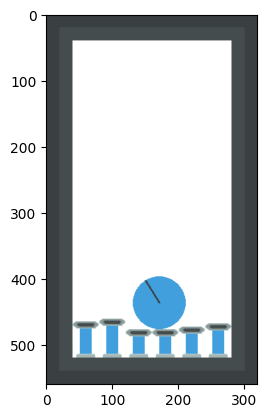

In [99]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env.reset()
img = plt.imshow(env.render())


for i in range(60):
   obs, reward, done, info, _ = env.last()
   act = model.predict(obs, deterministic=True)[0] if not done else None
   env.step(act)
   img.set_data(env.render()) # just update the data
   display.display(plt.gcf())
   display.clear_output(wait=True)

   if done:
    break

env.close()

### Reference

1. [HuggingFace RL Course Unit 7](https://huggingface.co/learn/deep-rl-course/unit7/introduction)
2. [Pettingzoo Tutorial](https://towardsdatascience.com/multi-agent-deep-reinforcement-learning-in-15-lines-of-code-using-pettingzoo-e0b963c0820b)
